# Collaboration and Competition

---
This notebook uses the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


### 1. Import necessary packages

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip install fastprogress
!pip install tqdm

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from ddpg_agent import Agent
from tqdm import tqdm
from fastprogress import progress_bar, master_bar



### 2. Start the Environment

In [3]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. Instantiate the agent

In [6]:
# initialize agents
agent1 = Agent(state_size, action_size)
agent2 = Agent(state_size, action_size)

In [7]:
def ddpg_tennis(n_episodes=1500, max_t=1000, train_mode=True):
    scores_deque = deque(maxlen=100)
    scores_all = []    
    mean_avg_scores = []
    achieved = False
    
    mb = master_bar(range(1, n_episodes+1))
    for i_episode in mb:
        env_info = env.reset(train_mode)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        scores = np.zeros(num_agents)
        for t in progress_bar(range(max_t), parent=mb):
            action1 = agent1.act(states[0], add_noise=True)    
            action2 = agent2.act(states[1], add_noise=True)    
            env_info = env.step([action1, action2])[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.max(scores))
        scores_all.append(np.max(scores))
        mean_avg_scores.append(np.mean(scores_deque))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore {:.2f}\tAverage Score {:.2f}'.format(i_episode, np.max(scores), np.mean(scores_deque)))
        
        if mean_avg_scores[-1]>=0.5 and achieved is False:
            print('Score of', mean_avg_scores[-1], 'achieved in', i_episode, 'episodes')
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
            achieved = True
        
    return scores_all, mean_avg_scores

### 5. Train DDPG agent

In [8]:
scores, avg_scores = ddpg_tennis()

/home/jmu/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Score 0.00	Average Score 0.00
Episode 200	Score 0.00	Average Score 0.00
Episode 300	Score 0.00	Average Score 0.00
Episode 400	Score 0.00	Average Score 0.00
Episode 500	Score 0.09	Average Score 0.02
Episode 600	Score 0.00	Average Score 0.01
Episode 700	Score 0.00	Average Score 0.03
Episode 800	Score 0.10	Average Score 0.04
Episode 900	Score 0.00	Average Score 0.05
Episode 1000	Score 0.00	Average Score 0.06
Episode 1100	Score 0.00	Average Score 0.06
Episode 1200	Score 0.19	Average Score 0.10
Episode 1300	Score 0.40	Average Score 0.23
Score of 0.5184000077843666 achieved in 1362 episodes
Episode 1400	Score 0.30	Average Score 0.91
Episode 1500	Score 0.00	Average Score 1.48


### 6. Plot reward against episodes

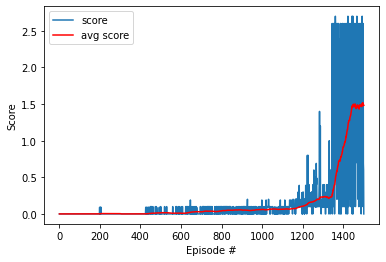

In [16]:
fig = plt.figure()
plt.subplot(1, 1, 1)
plt.plot(np.arange(1, len(scores)+1), scores, label='score')
plt.plot(np.arange(1, len(scores)+1), avg_scores, c='r', label='avg score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.savefig('score_per_episode_plot.png')
plt.show()


### 7. close the environment.

In [17]:
env.close()